# Task: Predict Apple Inc. Revenue for FY2018
June 1-3rd 2018

Specs:<br>
-  HP Omen 17 <br>
-  Ubuntu 16.04 <br>
-  NVIDIA 1060 <br>
-  Python 3

## (0) Initial thoughts

### What kind of problem is this?
-  It can be considered supervised or not
-  It requires deciding what data to use, finding it, preparing it and analysing it, and so this notebook will not begin with the customary initial data exploration
-  A value is to be predicted, so it is of a regression type

### What data is there?
Raw data is "short but wide", with potential for engineering.
"Short" because financial data goes stale quickly; Apple of 1982 is not Apple of 2018, so there's litte if anything positive to be gained by going too far back in time.
"Wide" because the financial statements contain many categories of data, beyond which there are __patent status reports, industry-wide data, upstream industry data (chip sales)__ and so on.
Of the available data, what is important? Hard to say (RFTs, GBTs will be able to tell us).
-  __[iPhones drive sales](http://investor.apple.com/secfiling.cfm?filingid=1193125-14-383437&cik=)__
-  __[Concensus estimates](https://markets.ft.com/data/equities/tearsheet/forecasts?s=AAPL:NSQ)__ FY2018 sales at \$261bn (Q3=\$52bn, Q4=\$59bn)

### How should I select and optimise features?
Irrelevant features should be removed to avoid misleading models; redundant features removed for computational efficiency; genuine indicators should be sought.
-  Selection by correlation assuming linear relationships
-  Use scikit learn's "mutual information" tool for more subtle relationships

### What models are likely to be appropriate?
Treating annual revenues as sequential data (with other features as inputs) suggests RNN/LSTM approach, perhaps even a __[sophisticated Deep Belief Network approach](https://www.mdpi.com/2071-1050/9/6/899/pdf)__ like pre-training with a Restricted Boltzman Machine then passing through a supervised process; my studies haven't gotten this far yet so this may involve studying more than time constraints allow at this stage.

Given the intrinsically small datasets I have in mind, ensembling over multiple approaches should help. This also suggests a Bayesian approach but I my studies have yet covered how to apply this (perhaps a prior derived from industry analysis, updated by "data" gathered from these models?). As long as I am using small datasets, my models will be prone to high bias, which I will account for with regularisation techniques. If I find a way to use all the NYSE data, for example, I will be able to use large tree-based models with cross-validation to detect subtle features.

I will mostly work with financial data (P&L, balance sheet, cash flow; share price data; economic indicators etc). This will be a structured dataset with high multicollinearity.

I suspect starting basic and building up will be enlightening in a way I cannot predict, so I will aim to proceed something like as follows:
1. Linear Regression (fast and simple so good for a quick baseline; however it will suffer due to the dataset's high multicollinearity)
2. Random Forest (gets around redundant features and captures non-linear relationships; liquidity is likely to be non-linear at the margin, as is the impact of accumulating uninvested cash, as shareholders start to apply pressure)
3. Gradient Boosted Trees (xgboost is built for speed and balancing variance with bias, and is famous for helping people win Kaggle competitions; it also has excellent in-built tools for hyperparameter tuning using cross-validation)
4. RNN (sequential data)
5. LSTM (captures cyclicality and possibly features like R&D spending or financial health in the past)
6. DBN (I came across a research paper in which this techique solves a similar problem to this one; very subtle features are captured.)

I won't use SVM Regression at this stage because it is quite slow compared to the added predictive power.

### What might help given more resources?
On a huge budget, satellite images of Apple store car parks and pedestrian traffic entering and exiting shops between now and the end of the financial year. Likewise, access to anonymised emails (provided by a data broker like __[Quandl](https://www.quandl.com)__) to count logs of purchases.

With more time, I would conduct __correlation analysis between performance and indicators to find which lag maximises predictive power__ - most obviously with patent features, and possibly balance sheet features. (The DBN article linked to above performed this analysis on pharmaceuticals and determined the time lag between patent features and performance to be three years.)

Another potentially useful analysis would be to study __historic broker error__.

### What are the immediate challenges?
-  (Q) How can I predict 2018 revenue without 2018 features?
-  (A) By treating the year n-1 data as the features for the prediction of revenue in year n. In the case of RNN-like approaches, I could use quarterly data and make a prediction followed by a prediction based on a prediction, though this is prone to instability.
-  (Q) What is the training/test data in this context (for methods like RF)?
-  (A) The test set will be the single point "2017 revenue". To reality-check the model I could run this against __Apple's competitors__, or even use broader markets for training.


In [1]:
## Imports
import csv
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error
import xgboost as xgb

import matplotlib.pyplot as plt

import timeit

## (0) Baseline (tiny dataset, linear regression)
Using __[this free source](https://quickfs.net/company/AAPL)__ I have downloaded 9 years of basic historic data from across the three financial statements 2008-2017 inclusive. I will run Linear Regression using the first 8 years of features to get a prediction for year 2017 (training on 7 years).

In [2]:
# Get the data from my machine, downloaded and converted to CSV
# First column is titles, first of which is revenue. First row is blank then year.
# Subsequent columns are 2009, 2010, ..., 2017.

In [3]:
# Load
df = pd.read_csv('AAPL_2009_2017_yearly.csv', index_col=0, header=0)

In [4]:
# Visualise - it's in financial reporting format
df

,2009,2010,2011,2012,2013,2014,2015,2016,2017
Revenue,42905,65225,108249,156508,170910,182795,233715,215639,229234
Revenue Growth,32.1%,52.0%,66.0%,44.6%,9.2%,7.0%,27.9%,-7.7%,6.3%
Gross Profit,17222,25684,43818,68662,64304,70537,93626,84263,88186
Gross Margin %,40.1%,39.4%,40.5%,43.9%,37.6%,38.6%,40.1%,39.1%,38.5%
Operating Profit,11740,18385,33790,55241,48999,52503,71230,60024,61344
Operating Margin %,27.4%,28.2%,31.2%,35.3%,28.7%,28.7%,30.5%,27.8%,26.8%
Earnings Per Share,$1.30,$2.16,$3.95,$6.31,$5.68,$6.45,$9.22,$8.31,$9.21
EPS Growth,69.4%,66.9%,82.7%,59.5%,-10.0%,13.6%,42.9%,-9.9%,10.8%
Return on Assets,18.9%,22.8%,27.1%,28.5%,19.3%,18.0%,20.4%,14.9%,13.9%
Return on Equity,31.3%,35.3%,41.7%,42.8%,30.6%,33.6%,46.2%,36.9%,36.9%


In [5]:
# Transpose to ML format, & visualise
df=df.T
df

,Revenue,Revenue Growth,Gross Profit,Gross Margin %,Operating Profit,Operating Margin %,Earnings Per Share,EPS Growth,Return on Assets,Return on Equity,Return on Invested Capital
2009,42905,32.1%,17222,40.1%,11740,27.4%,$1.30,69.4%,18.9%,31.3%,349.2%
2010,65225,52.0%,25684,39.4%,18385,28.2%,$2.16,66.9%,22.8%,35.3%,92.4%
2011,108249,66.0%,43818,40.5%,33790,31.2%,$3.95,82.7%,27.1%,41.7%,71.2%
2012,156508,44.6%,68662,43.9%,55241,35.3%,$6.31,59.5%,28.5%,42.8%,59.7%
2013,170910,9.2%,64304,37.6%,48999,28.7%,$5.68,-10.0%,19.3%,30.6%,39.2%
2014,182795,7.0%,70537,38.6%,52503,28.7%,$6.45,13.6%,18.0%,33.6%,35.6%
2015,233715,27.9%,93626,40.1%,71230,30.5%,$9.22,42.9%,20.4%,46.2%,40.5%
2016,215639,-7.7%,84263,39.1%,60024,27.8%,$8.31,-9.9%,14.9%,36.9%,31.5%
2017,229234,6.3%,88186,38.5%,61344,26.8%,$9.21,10.8%,13.9%,36.9%,29.9%


In [6]:
# Visualise 2011 row
df.iloc[2,:]

Revenue                       108249
Revenue Growth                 66.0%
Gross Profit                   43818
Gross Margin %                 40.5%
Operating Profit               33790
Operating Margin %             31.2%
Earnings Per Share             $3.95
EPS Growth                     82.7%
Return on Assets               27.1%
Return on Equity               41.7%
Return on Invested Capital     71.2%
Name: 2011, dtype: object

In [7]:
# Visualise Revenue column
df.Revenue

2009     42905
2010     65225
2011    108249
2012    156508
2013    170910
2014    182795
2015    233715
2016    215639
2017    229234
Name: Revenue, dtype: object

In [8]:
# Remove % and $ symbols from df
df.iloc[:,6] = df.iloc[:,6].replace({'\$':''}, regex = True)
df = df.replace({'\%':''}, regex = True)
df

,Revenue,Revenue Growth,Gross Profit,Gross Margin %,Operating Profit,Operating Margin %,Earnings Per Share,EPS Growth,Return on Assets,Return on Equity,Return on Invested Capital
2009,42905,32.1,17222,40.1,11740,27.4,1.30,69.4,18.9,31.3,349.2
2010,65225,52.0,25684,39.4,18385,28.2,2.16,66.9,22.8,35.3,92.4
2011,108249,66.0,43818,40.5,33790,31.2,3.95,82.7,27.1,41.7,71.2
2012,156508,44.6,68662,43.9,55241,35.3,6.31,59.5,28.5,42.8,59.7
2013,170910,9.2,64304,37.6,48999,28.7,5.68,-10.0,19.3,30.6,39.2
2014,182795,7.0,70537,38.6,52503,28.7,6.45,13.6,18.0,33.6,35.6
2015,233715,27.9,93626,40.1,71230,30.5,9.22,42.9,20.4,46.2,40.5
2016,215639,-7.7,84263,39.1,60024,27.8,8.31,-9.9,14.9,36.9,31.5
2017,229234,6.3,88186,38.5,61344,26.8,9.21,10.8,13.9,36.9,29.9


In [9]:
# Shift Revenue row one year back, then visualise.
# Now the first column is the target output for each row.
df.Revenue = df.Revenue.shift(-1)
df

,Revenue,Revenue Growth,Gross Profit,Gross Margin %,Operating Profit,Operating Margin %,Earnings Per Share,EPS Growth,Return on Assets,Return on Equity,Return on Invested Capital
2009,65225,32.1,17222,40.1,11740,27.4,1.30,69.4,18.9,31.3,349.2
2010,108249,52.0,25684,39.4,18385,28.2,2.16,66.9,22.8,35.3,92.4
2011,156508,66.0,43818,40.5,33790,31.2,3.95,82.7,27.1,41.7,71.2
2012,170910,44.6,68662,43.9,55241,35.3,6.31,59.5,28.5,42.8,59.7
2013,182795,9.2,64304,37.6,48999,28.7,5.68,-10.0,19.3,30.6,39.2
2014,233715,7.0,70537,38.6,52503,28.7,6.45,13.6,18.0,33.6,35.6
2015,215639,27.9,93626,40.1,71230,30.5,9.22,42.9,20.4,46.2,40.5
2016,229234,-7.7,84263,39.1,60024,27.8,8.31,-9.9,14.9,36.9,31.5
2017,NaN,6.3,88186,38.5,61344,26.8,9.21,10.8,13.9,36.9,29.9


In [10]:
X = df[["Revenue Growth", "Gross Profit", "Gross Margin %", "Operating Profit", "Operating Margin %",\
       "Earnings Per Share", "EPS Growth", "Return on Assets", "Return on Equity", "Return on Invested Capital"]]
X

,Revenue Growth,Gross Profit,Gross Margin %,Operating Profit,Operating Margin %,Earnings Per Share,EPS Growth,Return on Assets,Return on Equity,Return on Invested Capital
2009,32.1,17222,40.1,11740,27.4,1.30,69.4,18.9,31.3,349.2
2010,52.0,25684,39.4,18385,28.2,2.16,66.9,22.8,35.3,92.4
2011,66.0,43818,40.5,33790,31.2,3.95,82.7,27.1,41.7,71.2
2012,44.6,68662,43.9,55241,35.3,6.31,59.5,28.5,42.8,59.7
2013,9.2,64304,37.6,48999,28.7,5.68,-10.0,19.3,30.6,39.2
2014,7.0,70537,38.6,52503,28.7,6.45,13.6,18.0,33.6,35.6
2015,27.9,93626,40.1,71230,30.5,9.22,42.9,20.4,46.2,40.5
2016,-7.7,84263,39.1,60024,27.8,8.31,-9.9,14.9,36.9,31.5
2017,6.3,88186,38.5,61344,26.8,9.21,10.8,13.9,36.9,29.9


In [11]:
Y = df["Revenue"]
Y

2009     65225
2010    108249
2011    156508
2012    170910
2013    182795
2014    233715
2015    215639
2016    229234
2017       NaN
Name: Revenue, dtype: object

In [12]:
# Train-test split
X_train, y_train = X[:7], Y[:7]
X_test, y_test = X[7:8], Y[7]

In [13]:
# Fit a lin reg model with normalization (orders of magnitude of difference between features)
lin_reg = LinearRegression(normalize=True)
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [14]:
# Check accuracy for predicted revenue in 2016
guess=lin_reg.predict(X_test)
check=y_test
print('2017 prediction:', np.round(guess[0]), ' Actual:', check)

# For what it's worth, get a 2018 forecast.
print('2018:', np.round(lin_reg.predict(X[8:9])[0]))

2017 prediction: 145514.0  Actual: 229234
2018: 210489.0


In [15]:
# Double-check the model did at least fit the training data (yes, probably over-fitting)
print('training r2: ', lin_reg.score(X_train, y_train))
y_pred = lin_reg.predict(X_train)
print('training explained variance: ', explained_variance_score(y_train, y_pred))

training r2:  1.0
training explained variance:  1.0


## Evaluation: needs more & better data
Not surprisingly, this model performs very poorly, more because of the choice of data rather than the architecture, though the latter fails to capture accumulated investment in R&D, for example. There are no absolutes regarding balance sheet, recent R&D expenditure, accounts receivable etc.

This model shows a drop in forecast sales based on the drop in most parameters __the previous year__, whereas in reality the opposite phenomenon will occur (reversion to mean).

Having seen how significant the impact of future-relevant data is, I am going to divert attention away from model-improvement for now and focus on getting better data (raw and engineered).

This 2018 prediction doesn't even use May's 1H release.

## (1) NYSE data

In [16]:
# Load and visualise NYSE data
# NB I'm re-using variable names from exploration above
# NB Initially I will only use Apple data but will build a bigger model that predicts any company's revenue
df = pd.read_csv('fundamentals.csv', header=None)
df.sample(n=10)

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
799,798.0,HRB,2016-04-30,795126000.0,-70721000.0,5249000.0,1620.0,-99923000.0,758230000.0,96.0,...,1222298000.0,1039605000.0,23103000.0,2834672000.0,2857775000.0,3038153000.0,-766843000.0,2016.0,1.5,249511333.333
584,583.0,ETN,2015-12-31,2124000000.0,5000000.0,35000000.0,13.0,-506000000.0,11701000000.0,10.0,...,6616000000.0,4625000000.0,15186000000.0,15800000000.0,30986000000.0,20855000000.0,0.0,2015.0,4.25,465647058.824
363,362.0,COG,2012-12-31,368947000.0,-58037000.0,50635000.0,6.0,-927977000.0,695566000.0,7.0,...,270310000.0,444139000.0,2131447000.0,2484866000.0,4616313000.0,1204546000.0,-3349000.0,2012.0,0.63,209095238.095
94,93.0,ALXN,2014-12-31,439248000.0,-28000000.0,6000000.0,20.0,-137000000.0,2592167000.0,323.0,...,2796029000.0,606740000.0,3302018000.0,899944000.0,4201962000.0,2234000000.0,-382964000.0,2014.0,3.32,197891566.265
879,878.0,JEC,2016-09-30,1780265000.0,397268000.0,-36615000.0,5.0,-67688000.0,1168272000.0,37.0,...,2864470000.0,1782686000.0,4265276000.0,3094746000.0,7360022000.0,10964157000.0,0.0,2016.0,1.75,120264571.429
1490,1489.0,SYMC,2016-04-01,1335000000.0,38000000.0,10000000.0,68.0,-272000000.0,0.0,149.0,...,6959000000.0,4033000000.0,3676000000.0,8091000000.0,11767000000.0,3600000000.0,0.0,2016.0,3.71,670619946.092
647,646.0,FISV,2014-12-31,905000000.0,-42000000.0,0.0,23.0,-292000000.0,897000000.0,20.0,...,1444000000.0,1486000000.0,3295000000.0,6013000000.0,9308000000.0,5066000000.0,-4895000000.0,2014.0,3.03,248844884.488
1726,1725.0,WYNN,2012-12-31,553915000.0,-21019000.0,-8605000.0,194.0,-240985000.0,818821000.0,165.0,...,2202378000.0,1131377000.0,-259037000.0,7535631000.0,7276594000.0,5154284000.0,-1127947000.0,2012.0,4.87,103087474.333
345,344.0,CMI,2015-12-31,2978000000.0,103000000.0,33000000.0,19.0,-744000000.0,0.0,48.0,...,7947000000.0,3803000000.0,7406000000.0,7728000000.0,15134000000.0,19110000000.0,-3735000000.0,2015.0,7.86,177989821.883
1062,1061.0,MJN,2014-12-31,1166900000.0,-36500000.0,12300000.0,125.0,-186600000.0,-641300000.0,108.0,...,2331300000.0,1205300000.0,574300000.0,3189500000.0,3763800000.0,4409300000.0,-362600000.0,2014.0,3.55,202760563.38


In [17]:
# Shape
print('NYSE data has {} rows (company/year) and {} financials'.format(*df.shape))

NYSE data has 1782 rows (company/year) and 79 financials


In [18]:
# Locate Apple -> rows 9 through 12, ie df.iloc[9:13]
df.iloc[8:14,0:2]

,0,1
8,7.0,AAP
9,8.0,AAPL
10,9.0,AAPL
11,10.0,AAPL
12,11.0,AAPL
13,12.0,ABBV


In [19]:
# Locate Revenue (target) -> column -5
df.iloc[9,-5:]

74       1.7091e+11
75              0.0
76           2013.0
77            40.03
78    925231076.692
Name: 9, dtype: object

In [20]:
### Abandonding for now; this set has only 4 instances for each company. It may serve as something like a YOLO model,
# or sector analysis, but for now I'm going to focus on bigger data with engineering.

# The use of this data set would be to train a model to take, as input, a company's financials and revenue for 3 years 
# as well as its financials for the fourth year, and produce, as output, its revenue for the fourth year.
# To evaluate the model, lots of companies could be withheld for testing.
# Would they all have to be similar to Apple? If so, what would that mean? I suspect only a handful of established tech 
# giants would fit the bill, which makes the dataset small again.

## (2) Full Financials Quarterly Since the iPhone, Linear Regression
Plus engineered features like rates, nets, horizontal and vertical <br>
And other indicators like FoxConn share price, broker forecasts. Given more time I would verify which candidate indicators yield genuine correlation with future revenues. <br>

### Newly sourced data
AAPL financials from __[here.](https://ycharts.com/financials/AAPL/cash_flow_statement/quarterly/5)__ <br>
FoxConn from __[here.](http://performance.morningstar.com/stock/performance-return.action?p=price_history_page&t=2354&region=twn&culture=en-US)__

The data goes up to Q218, so I'll use a one-quarter lag to predict Q3 and a two-quarter lag to predict Q4 (so the learning accounts for seasonality), summing relevant quarters to answer the original question.

In [21]:
# It's overkill because there is duplication among the financial features, so ideally I'll save time by trimming this set down a bit.
# However there are still only about 45 data points.
# I'll go back as far as March 2007, up to March 2018 inclusive.
# Both spreadsheets have more recent data left

In [22]:
# First transpose the FoxConn data so it can be merged (careful to match up dates) with AAPL statements.
file_fox = 'FoxConn_2354_Historical_Prices.csv'
df_foxconn = pd.read_csv(file_fox, thousands=',')
df_foxconn

,,,,,Foxconn Technology Co Ltd (2354) Historical Prices
Date,Open,High,Low,Close,Volume
06/01/2018,79.80,80.10,71.60,74.70,"2,707,583"
03/30/2018,85.20,88.70,76.00,80.00,"3,442,512"
12/29/2017,88.60,96.60,81.10,85.20,"5,904,537"
09/29/2017,92.00,102.00,85.90,87.50,"8,277,124"
06/30/2017,92.50,96.50,83.00,91.80,"6,220,318"
03/31/2017,85.30,97.80,83.80,92.50,"3,456,955"
12/30/2016,92.90,96.90,80.70,85.30,"4,171,424"
09/30/2016,74.75,92.50,72.28,92.20,"4,821,702"
06/30/2016,71.68,75.35,61.98,74.65,"4,560,395"


In [23]:
df_foxconn = df_foxconn.T
df_foxconn

,Date,06/01/2018,03/30/2018,12/29/2017,09/29/2017,06/30/2017,03/31/2017,12/30/2016,09/30/2016,06/30/2016,...,12/31/2008,09/30/2008,06/30/2008,03/31/2008,12/31/2007,09/28/2007,06/29/2007,03/30/2007,12/29/2006,10/24/2006
,Open,79.80,85.20,88.60,92.00,92.50,85.30,92.90,74.75,71.68,...,64.23,79.83,101.55,148.94,212.69,195.74,184.21,192.79,161.40,161.40
,High,80.10,88.70,96.60,102.00,96.50,97.80,96.90,92.50,75.35,...,66.40,99.86,135.96,151.48,223.41,218.89,201.87,216.10,193.04,161.64
,Low,71.60,76.00,81.10,85.90,83.00,83.80,80.70,72.28,61.98,...,33.82,61.81,78.98,88.01,125.24,156.27,134.59,128.40,134.59,158.45
,Close,74.70,80.00,85.20,87.50,91.80,92.50,85.30,92.20,74.65,...,47.91,62.99,79.26,101.55,148.94,213.25,168.50,184.21,191.57,159.43
Foxconn Technology Co Ltd (2354) Historical Prices,Volume,"2,707,583","3,442,512","5,904,537","8,277,124","6,220,318","3,456,955","4,171,424","4,821,702","4,560,395",...,"675,122,647","12,663,892","17,733,464","12,718,462","9,440,898","8,761,810","8,509,744","10,060,174","8,184,167",�


In [24]:
df_foxconn.to_csv('foxconn_horizontal.csv')
# I've now merged them both by hand and saved the CSV - not very elegent, I know, but only 5 columns.

In [25]:
# All data is now on horizontal CSV file. Let's start with this before adding more features.
df = pd.read_csv('AAPL_2005_2017_Q_large.csv',skipinitialspace=True).fillna(0)

In [26]:
df.sample(5)

,Income (Quarterly),2018-03,2017-12,2017-09,2017-06,2017-03,2016-12,2016-09,2016-06,2016-03,...,2008-03,2007-12,2007-09,2007-06,2007-03,2006-12,2006-09,2006-06,2006-03,2005-12
110,Net Debt Issuance,-501.00M,6.971B,6.923B,9.237B,10.47B,2.385B,2.581B,4.395B,16.32B,...,0,0,0,0,0,0,0,0,0,0
70,Current Portion of Long Term Debt,20.48B,18.48B,18.47B,18.48B,13.99B,13.99B,11.60B,16.00B,10.50B,...,0,0,0,0,0,0,0,0,0,0
47,Land and Improvements,14.93B,14.19B,13.59B,12.53B,11.75B,10.93B,10.18B,9.108B,8.391B,...,796.00M,774.00M,762.00M,727.00M,685.00M,674.00M,626.00M,611.00M,485.00M,361.00M
125,Income Tax Paid Supplemental Data,-9.891B,3.551B,1.839B,16.63B,-10.39B,3.51B,1.454B,2.36B,3.232B,...,502.00M,251.00M,0,0,0,0,0,0,0,0
34,Cash and Equivalents,45.06B,27.49B,20.29B,18.57B,15.16B,16.37B,20.48B,18.24B,21.51B,...,9.07B,9.162B,9.352B,7.118B,7.095B,7.159B,6.392B,8.013B,6.346B,4.15B


In [27]:
# Remove letters standard for million and billion (no % or $ signs)
df = df.replace({'B':'', 'M':''}, regex = True)
df.sample(5)

,Income (Quarterly),2018-03,2017-12,2017-09,2017-06,2017-03,2016-12,2016-09,2016-06,2016-03,...,2008-03,2007-12,2007-09,2007-06,2007-03,2006-12,2006-09,2006-06,2006-03,2005-12
17,Provision for Income Taxes,2.346,6.965,3.203,2.591,3.655,6.289,3.174,2.673,3.626,...,432.00,745.00,325.00,378.00,364.00,444.00,179.00,189.00,195.00,266.00
90,Total Depreciation and Amortization,2.739,2.745,2.484,2.354,2.332,2.987,2.548,2.526,2.477,...,0,0,-224.00,81.00,69.00,74.00,66.00,57.00,50.00,52.00
64,Current Tax Payable,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
129,Low,76,81.1,85.9,83,83.8,80.7,72.28,61.98,56.63,...,88.01,125.24,156.27,134.59,128.4,134.59,158.45,0,0,0
105,Total Net Change in Investments,32.80,-10.42,-5.46,-749.00,-11.36,-15.58,-3.407,-184.00,-10.98,...,-1.149,-3.249,615.00,-1.17,-765.00,-992.00,-2.565,706.00,2.68,211.00


In [28]:
# Transpose and verify which rows to keep, and which column is target (revenue)
df = df.T

In [29]:
df.iloc[0:2]

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
Income (Quarterly),Operating Revenue,Revenue,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,...,Issuance of Debt,Debt Repayment,Repurchase of Capital Stock,Income Tax Paid Supplemental Data,Interest Paid Supplemental Data,Open,High,Low,Close,Volume
2018-03,61.14,61.14,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,...,0,-500.00,-22.76,-9.891,-1.979,85.2,88.7,76,80,3442512


In [30]:
# Delete operating revenue - this is identical to revenue
# Careful: column 0 is the one labelled 1 above.
df = df.drop(0,1)
df.iloc[0:2]

,1,2,3,4,5,6,7,8,9,10,...,122,123,124,125,126,127,128,129,130,131
Income (Quarterly),Revenue,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,Operating Income,...,Issuance of Debt,Debt Repayment,Repurchase of Capital Stock,Income Tax Paid Supplemental Data,Interest Paid Supplemental Data,Open,High,Low,Close,Volume
2018-03,61.14,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,...,0,-500.00,-22.76,-9.891,-1.979,85.2,88.7,76,80,3442512


In [31]:
df.iloc[1:3,3:8]

,4,5,6,7,8
2018-03,4.15,3.378,792.00,1.505,713.00
2017-12,4.231,3.407,734.00,1.452,718.00


In [32]:
# Shape
print('Indicators data consists in {} rows (quarter ending) and {} indicators'.format(*df.shape))

Indicators data consists in 51 rows (quarter ending) and 131 indicators


In [33]:
# Apply lag
# NB more recent data at the top this time
df.iloc[:,0]  = df.iloc[:,0].shift(+1)

In [34]:
# Note to self to make sure indexing accounts to initial rows/headers, and look at lag
df.iloc[1:3,0:8]

,1,2,3,4,5,6,7,8
2018-03,Revenue,37.72,23.42,4.15,3.378,792.00,1.505,713.00
2017-12,61.14,54.38,33.91,4.231,3.407,734.00,1.452,718.00


In [35]:
# Split features from target
X=df.iloc[1:-5,1:]
X

,2,3,4,5,6,7,8,9,10,11,...,122,123,124,125,126,127,128,129,130,131
2018-03,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,1.505,...,0,-500.00,-22.76,-9.891,-1.979,85.2,88.7,76,80,3442512
2017-12,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,26.27,1.452,...,6.969,0,-10.10,3.551,623.00,88.6,96.6,81.1,85.2,5904537
2017-09,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,1.368,...,6.937,0,-7.795,1.839,636.00,92,102,85.9,87.5,8277124
2017-06,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,1.327,...,10.75,-3.50,-7.093,16.63,2.463,92.5,96.5,83,91.8,6220318
2017-03,32.30,20.59,3.718,2.776,530.00,1.282,752.00,6.494,14.10,1.282,...,10.98,0,-7.161,-10.39,-1.504,85.3,97.8,83.8,92.5,3456955
2016-12,48.18,30.18,3.946,2.871,525.00,1.224,699.00,6.817,23.36,1.224,...,0,0,-10.85,3.51,497.00,92.9,96.9,80.7,85.3,4171424
2016-09,29.04,17.81,3.482,2.57,450.00,1.036,586.00,6.052,11.76,1.036,...,6.97,0,-6.026,1.454,424.00,74.75,92.5,72.28,92.2,4821702
2016-06,26.25,16.11,3.441,2.56,409.00,1.036,627.00,6.001,10.10,1.036,...,2.40,-2.50,-10.17,2.36,327.00,71.68,75.35,61.98,74.65,4560395
2016-03,30.64,19.92,3.423,2.511,321.00,986.00,665.00,5.934,13.99,986.00,...,15.58,0,-6.667,3.232,169.00,68.91,73.17,56.63,71.49,6632919
2015-12,45.45,30.42,3.848,2.404,276.00,941.00,665.00,6.252,24.17,941.00,...,0,0,-6.863,3.398,396.00,94.06,97.33,65.64,68.91,8247570


In [36]:
y=df.iloc[1:-5,0]
y
# NB first entry, nonsense, won't be used.

2018-03    Revenue
2017-12     61.14 
2017-09     88.29 
2017-06     52.58 
2017-03     45.41 
2016-12     52.90 
2016-09     78.35 
2016-06     46.85 
2016-03     42.36 
2015-12     50.56 
2015-09     75.87 
2015-06     51.50 
2015-03     49.60 
2014-12     58.01 
2014-09     74.60 
2014-06     42.12 
2014-03     37.43 
2013-12     45.65 
2013-09     57.59 
2013-06     37.47 
2013-03     35.32 
2012-12     43.60 
2012-09     54.51 
2012-06     35.97 
2012-03     35.02 
2011-12     39.19 
2011-09     46.33 
2011-06     28.27 
2011-03     28.57 
2010-12     24.67 
2010-09     26.74 
2010-06     20.34 
2010-03     15.70 
2009-12     13.50 
2009-09     15.68 
2009-06     12.21 
2009-03     9.734 
2008-12     9.084 
2008-09     11.88 
2008-06     12.91 
2008-03     7.464 
2007-12     7.512 
2007-09     9.608 
2007-06     6.789 
2007-03      5.41 
Name: 1, dtype: object

/home/jesse/anaconda2/envs/dl_env_1/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=4,center=False).mean()


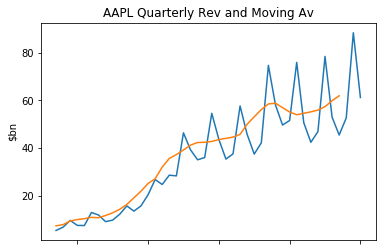

In [37]:
# Visualise Revenues (cyclicality, trends, magnitude)
fig, ax = plt.subplots()
rev = y.iloc[1:] # extract numbers for revenue
rev = rev.astype(float)
rev.plot()
plt.gca().invert_xaxis() # so time increases going right
moving_av = pd.rolling_mean(rev,4)
moving_av.plot()

plt.title('AAPL Quarterly Rev and Moving Av')
plt.ylabel("$bn")

plt.show()

In [38]:
# train-test split - skipping first row
X_train, X_test = X.iloc[2:45], X.iloc[1:2]
y_train, y_test = y.iloc[2:45], y.iloc[1:2]

In [39]:
# Fit a lin reg model with normalization (orders of magnitude of difference between features)
lin_reg = LinearRegression(normalize=True, n_jobs=-1)
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

In [40]:
# Double-check the model did at least fit the training data (-> yes, probably over-fitting)
print('training r2: ', lin_reg.score(X_train, y_train))
y_pred = lin_reg.predict(X_train)
print('training explained variance: ', explained_variance_score(y_train, y_pred))

training r2:  1.0
training explained variance:  1.0


In [41]:
print(X_train.shape, X_test.shape, X.shape, X.iloc[1,:].shape, X.iloc[1:2].shape)

(43, 130) (1, 130) (45, 130) (130,) (1, 130)


In [42]:
# Check accuracy for predicted revenue in 2018Q2
guess=lin_reg.predict(X_test)
check=y_test
print('2018 Q2 prediction:', np.round(guess[0]), ' Actual:', check)

# For what it's worth, get a 2018 forecast.
#print('2018:', np.round(lin_reg.predict(X[8:9])[0]))

2018 Q2 prediction: 65.0  Actual: 2017-12    61.14 
Name: 1, dtype: object


In [43]:
# Predict Q3 revenue -> 800bn??? Something's very wrong. Let's visualise all predictions vs actual and see if 
# cyclicality has been discovered.
Q3_pred = lin_reg.predict(X.iloc[0:1])
print('2018 Q3 prediction:', np.round(Q3_pred[0]))

2018 Q3 prediction: 803.0


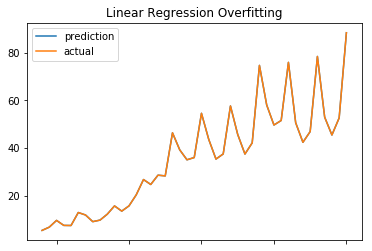

In [44]:
# Plot to see what's going on -> overfitting
fig, ax = plt.subplots()
plt.plot(y_pred,label='prediction') # predictions
rev.iloc[1:].plot(ax=ax, label='actual') # actual revenue
plt.gca().invert_xaxis() # so time increases going right
plt.title('Linear Regression Overfitting')
plt.legend()
plt.show()

# NB you only see one graph because the other is exactly behind it - I've checked by lagging.

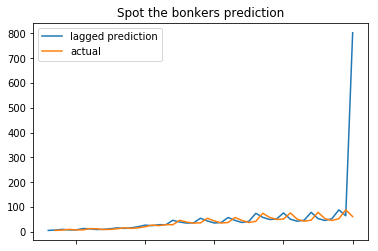

In [45]:
# Plot all predictions including latest anomaly
# Deliberately plotted with lag to make both graphs visible
all_pred = lin_reg.predict(X.iloc[0:45])
fig, ax = plt.subplots()
plt.plot(all_pred,label='lagged prediction') # predictions
rev.iloc[0:].plot(ax=ax, label='actual') # actual revenue
plt.gca().invert_xaxis() # so time increases going right
plt.title("Spot the bonkers prediction")
plt.legend()
plt.show()

### Feature Pruning
Which features are helpful? Did FoxConn share data help or fit a model to irrelevant noise? I'll move to Random Trees to analyse this.

## Evaluation
A mixed result: overfitting the data and predicting a fairly accurate Q2 but a wildly large Q3 revenue. Plenty of room for improvement with features analysis followed by enhancement. Rather than find the problem, I will proceed to the obvious improvements.

NB given how off the prediction is I'm not going to run the second stage of this model - predicting with a lag of two quarters - to get a FY18 prediction.

## (3) Same data, analyse features with Boosted Random Forests

### 1-quarter lag

In [46]:
# Data - now withhold a few random quarters for validation
X_train_rf, X_val_rf, y_train_rf, y_val_rf = train_test_split(X.iloc[1:],y.iloc[1:],test_size=4, random_state=2)

# Model
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=256,learning_rate=0.003)
# Fit model
gbrt.fit(X_train_rf,y_train_rf)

# Optimise hyperparameters
errors = [mean_squared_error(y_val_rf,y_pred_rf)
       for y_pred_rf in gbrt.staged_predict(X_val_rf)]
best_n_estimators = np.argmin(errors)
print(best_n_estimators)
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)
gbrt_best.fit(X_train_rf, y_train_rf)

255


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=255, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [47]:
# Did the model fit the data? -> depends on hyperparams
y_pred_rf_train = gbrt_best.predict(X_train_rf)
print('train error:',mean_squared_error(y_pred_rf_train, np.asarray(y_train_rf, dtype=np.float64)))

# Did the model generalise to test set? -> depends on hyperparams
y_pred_rf_val = gbrt_best.predict(X_val_rf)
print('test error:', mean_squared_error(y_pred_rf_val, np.asarray(y_val_rf, dtype=np.float64)))

train error: 2.2538456367963178e-05
test error: 32.82074699216193


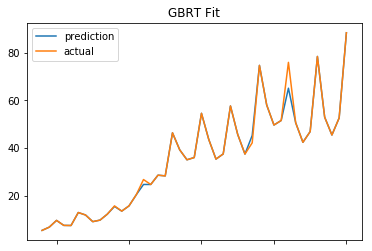

In [48]:
# Plot to see what's going on -> depends on hyperparams but tends to overfit
# Get predictions for plotting
y_pred_gbrt = gbrt_best.predict(X_train)
# Set up plots
fig, ax = plt.subplots()
plt.plot(y_pred_gbrt,label='prediction') # predictions
rev.iloc[1:].plot(ax=ax, label='actual') # actual revenue
plt.gca().invert_xaxis() # so time increases going right
plt.title('GBRT Fit')
plt.legend()
plt.show()

# NB it doesn't fit as exactly as linear regression did above. Let's see if it generalises. If not, tune hyperparams.
# Then investigate features.

In [49]:
# Check accuracy for predicted revenue in 2018Q2 -> very accurate but probably in training set
guess=gbrt_best.predict(X_test)
check=y_test
print('2018 Q2 prediction:', np.round(guess[0]), ' Actual:', check)


2018 Q2 prediction: 61.0  Actual: 2017-12    61.14 
Name: 1, dtype: object


In [50]:
# Predict Q3 revenue -> 68bn - much more reasonable at a glance, though well above brokers. We'll see in a few weeks.
Q3_pred = gbrt_best.predict(X.iloc[0:1])
print('2018 Q3 prediction:', np.round(Q3_pred[0]))

2018 Q3 prediction: 67.0


### Get a Q4 prediction by re-running with a 2-Q lag

In [51]:
# Apply lag
df2 = df
df2.iloc[:,0]  = df.iloc[:,0].shift(+1) # Note to self: this update "df"

In [52]:
# Visualise
df2
# NB now the first two rows have no target.
# NB the prediction of Q3 with this model can serve as a reality check.

,1,2,3,4,5,6,7,8,9,10,...,122,123,124,125,126,127,128,129,130,131
Income (Quarterly),NaN,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,Operating Income,...,Issuance of Debt,Debt Repayment,Repurchase of Capital Stock,Income Tax Paid Supplemental Data,Interest Paid Supplemental Data,Open,High,Low,Close,Volume
2018-03,NaN,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,...,0,-500.00,-22.76,-9.891,-1.979,85.2,88.7,76,80,3442512
2017-12,Revenue,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,26.27,...,6.969,0,-10.10,3.551,623.00,88.6,96.6,81.1,85.2,5904537
2017-09,61.14,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,...,6.937,0,-7.795,1.839,636.00,92,102,85.9,87.5,8277124
2017-06,88.29,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,...,10.75,-3.50,-7.093,16.63,2.463,92.5,96.5,83,91.8,6220318
2017-03,52.58,32.30,20.59,3.718,2.776,530.00,1.282,752.00,6.494,14.10,...,10.98,0,-7.161,-10.39,-1.504,85.3,97.8,83.8,92.5,3456955
2016-12,45.41,48.18,30.18,3.946,2.871,525.00,1.224,699.00,6.817,23.36,...,0,0,-10.85,3.51,497.00,92.9,96.9,80.7,85.3,4171424
2016-09,52.90,29.04,17.81,3.482,2.57,450.00,1.036,586.00,6.052,11.76,...,6.97,0,-6.026,1.454,424.00,74.75,92.5,72.28,92.2,4821702
2016-06,78.35,26.25,16.11,3.441,2.56,409.00,1.036,627.00,6.001,10.10,...,2.40,-2.50,-10.17,2.36,327.00,71.68,75.35,61.98,74.65,4560395
2016-03,46.85,30.64,19.92,3.423,2.511,321.00,986.00,665.00,5.934,13.99,...,15.58,0,-6.667,3.232,169.00,68.91,73.17,56.63,71.49,6632919


In [53]:
df2.iloc[3:5]

,1,2,3,4,5,6,7,8,9,10,...,122,123,124,125,126,127,128,129,130,131
2017-09,61.14,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,...,6.937,0,-7.795,1.839,636.00,92,102,85.9,87.5,8277124
2017-06,88.29,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,...,10.75,-3.50,-7.093,16.63,2.463,92.5,96.5,83,91.8,6220318


In [54]:
# Split features from target
X2 = df2.iloc[3:-5,1:]
y2 = df2.iloc[3:-5,0]

# train-test split
X2_train_rf, X2_val_rf, y2_train_rf, y2_val_rf = train_test_split(X2,y2,test_size=4, random_state=2)

# Model
gbrt_2 = GradientBoostingRegressor(max_depth=2, n_estimators=512,learning_rate=0.001)
# Fit model
gbrt_2.fit(X2_train_rf,y2_train_rf)

# Optimise hyperparameters
errors_2 = [mean_squared_error(y2_val_rf,y2_pred_rf)
       for y2_pred_rf in gbrt_2.staged_predict(X2_val_rf)]
best_n_estimators_2 = np.argmin(errors_2)
print(best_n_estimators_2)
gbrt_best_2 = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators_2)
gbrt_best_2.fit(X2_train_rf, y2_train_rf)

# Did the model fit the data? -> depends on hyperparams
y2_pred_rf_train = gbrt_best_2.predict(X2_train_rf)
print('train error:',mean_squared_error(y2_pred_rf_train, np.asarray(y2_train_rf, dtype=np.float64)))

# Did the model generalise to test set? -> depends on hyperparams
y2_pred_rf_val = gbrt_best_2.predict(X2_val_rf)
print('test error:', mean_squared_error(y2_pred_rf_val, np.asarray(y2_val_rf, dtype=np.float64)))

511
train error: 9.831918883809776e-08
test error: 139.5428307694729


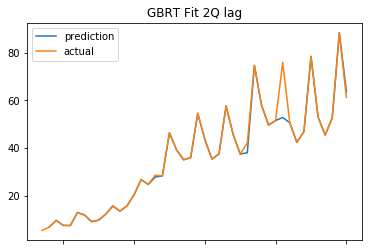

In [55]:
# Plot to see what's going on -> depends on hyperparams but tends to overfit
# Get predictions for plotting
y2_pred_gbrt = gbrt_best_2.predict(X_train)
# Set up plots
fig, ax = plt.subplots()
plt.plot(y2_pred_gbrt,label='prediction') # predictions
rev.iloc[0:].plot(ax=ax, label='actual') # actual revenue
plt.gca().invert_xaxis() # so time increases going right
plt.title('GBRT Fit 2Q lag')
plt.legend()
plt.show()

In [56]:
# Predict Q3, Q4
guess=gbrt_best_2.predict(X.iloc[1:2])
check=y_test
print('2018 Q3 prediction:', np.round(guess[0]),'vs previous prediction:', np.round(Q3_pred[0]))

# Predict Q4 revenue 
Q4_pred = gbrt_best_2.predict(X.iloc[0:1])
print('2018 Q4 prediction:', np.round(Q4_pred[0]))

# FY2018 prediction
H1 = np.sum(np.asarray(y2.iloc[0:2],dtype=np.float64))
FY2018_pred = np.sum([H1, Q3_pred[0], Q4_pred[0]])
print(round(FY2018_pred))

2018 Q3 prediction: 64.0 vs previous prediction: 67.0
2018 Q4 prediction: 58.0
275.0


## Prediction with Gradient-boosted trees: \$272bn

This uses the Q3 estimate from the 1-quarter-lag model, and the Q4 from the 2-Q-lag model, that is, I have used the most recent data as far as possible.

Brokers estimate Q3 at \$52bn, Q4 at \$59bn, givng FY at \$261bn (\$256-264bn), putting this prediction about 5% above consensus.

This would not be historically infeasible given __[earnings surprises of 1.5-11% in the last four reporting cycles](https://www.nasdaq.com/symbol/aapl/earnings-surprise)__, though FY surprises will be less than quarterly surprises given half the information is already known.

### Conviction: low
This is because the 2-quarter-lag model appears to generalise poorly, based on the high MSE on the (small) test set.


In [57]:
### Get rolling 3-quarter prediction?

### Feats
# Analyse importance: trim redundant, delete unhelpful
# New: quarter (doesn't matter if doesn't correspond to FY convention), patents, broker pred, 
# https://www.quandl.com/databases/ZEE newly sourced data

## (4) Analyse data, (pruning irrelevant features?), adding new features - XGBoost

Pruning is not crucial with Random Forest-based learning, but if time I will delete those features contributing less than a certain threshold of the information.

2 0.0012920242673276042
3 9.105026641911779e-06
4 0.0089136427934663
5 0.000703030569934845
6 0.0
7 0.0005406430037444264
8 5.783867278746104e-05
9 0.00013030965499531862
10 0.004166025541775548
11 0.0
12 0.0
13 0.0
14 0.001959017676816709
15 0.0
16 0.001685227339781055
17 0.01737178961926139
18 0.00465908995517432
19 0.004326678200549453
20 0.0030791080329794682
21 0.0026719199090628975
22 0.00044313350743955984
23 0.0011717380962579995
24 0.0007239426643747507
25 0.0018486578462778701
26 0.0001096918119759001
27 0.001197579887258476
28 0.00248981169993625
29 0.0019803248150088728
30 2.9407802257671555e-05
31 0.0002564885765899007
32 0.0
33 0.0011555666695706335
34 0.001990418907391126
35 0.0015048631352877217
36 8.132906941207467e-05
37 0.012422742703505284
38 0.02378090005052819
39 0.0009376196343517297
40 0.0046880024787299196
41 0.0008514743807632563
42 0.009732629531321507
43 0.0
44 0.0011260955536440452
45 0.005433016649875707
46 0.00044203740386578304
47 1.3725859382050833e-05


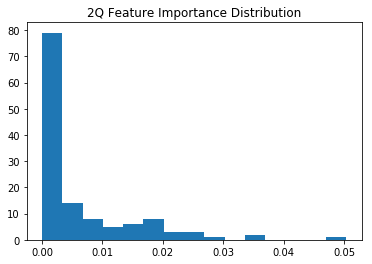

In [58]:
# Feature importance in 2_Q model
features_list = []
for name, score in zip(X_train_rf.columns, gbrt_best_2.feature_importances_):
    print(name, score)
    features_list.append([name, score])
# Convert to array
features_array = np.array(features_list)
# Print max importance
print('max importance:', np.max(features_array[:,1]))
# visualise importance distribution
plt.hist(features_array[:,1],bins=15,)
plt.title('2Q Feature Importance Distribution')
plt.show()
# Most features contribute negligible information

In [59]:
# Which are the top features?
a = features_array
a[a[:,1].argsort()][::-1]
"""
99 at 5.0%
56 at 3.7%
72 at 3.4%
"""

'\n99 at 5.0%\n56 at 3.7%\n72 at 3.4%\n'

In [60]:
a_sorted = a[a[:,1].argsort()][::-1]
top_a = list(a_sorted[0:15,0])

In [61]:
# Get top 30 features
a_ind = []
for num in top_a:
    a_ind.append(int(num))
    
for i in a_ind:
    print (df.iloc[0,i-1])

Changes in Working Capital
Other Intangible Assets
Current Deferred Revenue
Net Change in Capital Expenditures
Income Tax Paid Supplemental Data
Other Receivables
Close
Non-Current Deferred Liabilities
Other Long Term Liabilities
Low
Cash from Other Financing Activities
Net Debt Issuance
Issuance of Capital Stock
Common Stock Issuance
Stock ased Compensation


2 0.004467134704408399
3 0.0012358798508004059
4 0.0
5 0.01203842748097252
6 0.00023254299320251724
7 0.000342760023173948
8 0.0005401492983320373
9 0.0001731498750467393
10 0.0
11 0.00034951499608456546
12 0.0
13 0.00031343603991226604
14 0.015551620087961598
15 0.0
16 0.0005310753816094795
17 0.007123923800402082
18 0.00047160830015794834
19 0.001836594309326739
20 0.00039259624428737765
21 1.7123124706770235e-05
22 0.014768924241385999
23 0.0016699627592731473
24 0.001868275792000051
25 0.0
26 0.0007519852863886937
27 0.0021343473318122777
28 0.0014242223520972257
29 0.0016103952187787253
30 0.002339473305187214
31 0.0029943916429267877
32 4.7540947967907584e-05
33 0.005903584382171838
34 0.002230904357071134
35 0.014284051041960585
36 7.659096093647571e-06
37 0.0016815779864671678
38 0.002212683841854737
39 0.016971138460353502
40 0.032768027210823794
41 0.0244925901769364
42 0.013423063791657171
43 0.0009018812940833573
44 0.00017299093088841896
45 0.016002579860451137
46 0.019942

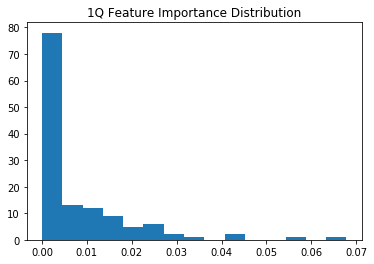

Net Other Investing Changes
Other Noncash Items
Change in Receivables
Total Net Change in Investments
Raw aterials Inventory
Goodwill
Volume
Total Depreciation, Amortization, Depletion
Cash from Investing
Net PP&E
Finished Goods Inventory
Low
Accounts Payable
Retained Earnings
Net Change in PP&E


In [62]:
# Feature importance in 1_Q model
features_list = []
for name, score in zip(X_train_rf.columns, gbrt_best.feature_importances_):
    print(name, score)
    features_list.append([name, score])
features_array = np.array(features_list)
print('max importance: ', np.max(features_array[:,1]))

# Plot feat importance
plt.hist(features_array[:,1],bins=15,)
plt.title('1Q Feature Importance Distribution')
plt.show()
# Most features contribute negligible information

# Which are the top features?
b = features_array
#print(b[b[:,1].argsort()][::-1][0:3])
b_sorted = b[b[:,1].argsort()][::-1]
top_b = list(b_sorted[0:15,0])

# Get top 15 features
b_ind = []
for num in top_b:
    b_ind.append(int(num))
    
for i in b_ind:
    print (df.iloc[0,i-1])

In [63]:
# NB Foxconn features are all very important in both models. Let's do some engineering and adding.
# Add AAAPL share price, broker forecasts, patent info
# Engineer: cash growth, share price change Q-Q, Y-Y (a sudden drop indicates market knowledge etc)
# Add competitor info
# Add different translations of target to simulate time-series prediction

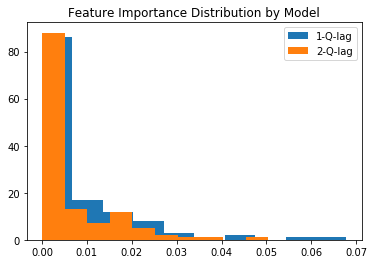

In [64]:
plt.hist(b[:,1],label='1-Q-lag')
plt.hist(a[:,1],label='2-Q-lag')
plt.title('Feature Importance Distribution by Model')
plt.legend()
plt.show()

### Add AAPL share data

In [65]:
colnames=['A_Date', 'A_open', 'A_High', 'A_Low', 'A_Close', 'A_Volume'] 
df_apple_shares = pd.read_csv("AAPL_Historical_Prices.csv",names=colnames,header='infer')
# we'll need rows from march going backwards:
df_apple_shares.iloc[2:48,1:]


,A_open,A_High,A_Low,A_Close,A_Volume
2,167.88,190.37,160.63,190.24,29898121
3,169.23,183.5,150.24,167.78,27936860
4,154.26,177.2,152.46,169.23,25975599
5,144.88,164.94,142.41,154.12,27485338
6,143.71,156.65,140.06,144.02,26229445
7,115.82,144.5,114.76,143.66,26225977
8,112.71,118.69,104.08,115.82,31114558
9,95.49,116.18,94.37,113.05,34654261
10,108.78,112.39,89.47,95.6,39091622
11,105.26,110.42,92.39,108.99,43481203


In [66]:
# Add Apple share data
df_old = df.iloc[0:46]
df_old.reset_index(drop=True, inplace=True)
df_right = df_apple_shares.iloc[1:47,1:]
df_right.reset_index(drop=True, inplace=True)

df_new = pd.concat([df_old, df_right], axis=1)
df_new

,1,2,3,4,5,6,7,8,9,10,...,127,128,129,130,131,A_open,A_High,A_Low,A_Close,A_Volume
0,NaN,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,Operating Income,...,Open,High,Low,Close,Volume,Open,High,Low,Close,Volume
1,NaN,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,...,85.2,88.7,76,80,3442512,167.88,190.37,160.63,190.24,29898121
2,Revenue,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,26.27,...,88.6,96.6,81.1,85.2,5904537,169.23,183.5,150.24,167.78,27936860
3,61.14,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,...,92,102,85.9,87.5,8277124,154.26,177.2,152.46,169.23,25975599
4,88.29,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,...,92.5,96.5,83,91.8,6220318,144.88,164.94,142.41,154.12,27485338
5,52.58,32.30,20.59,3.718,2.776,530.00,1.282,752.00,6.494,14.10,...,85.3,97.8,83.8,92.5,3456955,143.71,156.65,140.06,144.02,26229445
6,45.41,48.18,30.18,3.946,2.871,525.00,1.224,699.00,6.817,23.36,...,92.9,96.9,80.7,85.3,4171424,115.82,144.5,114.76,143.66,26225977
7,52.90,29.04,17.81,3.482,2.57,450.00,1.036,586.00,6.052,11.76,...,74.75,92.5,72.28,92.2,4821702,112.71,118.69,104.08,115.82,31114558
8,78.35,26.25,16.11,3.441,2.56,409.00,1.036,627.00,6.001,10.10,...,71.68,75.35,61.98,74.65,4560395,95.49,116.18,94.37,113.05,34654261
9,46.85,30.64,19.92,3.423,2.511,321.00,986.00,665.00,5.934,13.99,...,68.91,73.17,56.63,71.49,6632919,108.78,112.39,89.47,95.6,39091622


### Add patent data

In [67]:
## Apple Patents awarded in a given year - with several lags (if no time., lag=3 years)
# Sources:
# https://www.ificlaims.com/rankings-misc-top-50-2015.htm
# https://www.uspto.gov/web/offices/ac/ido/oeip/taf/all_tech.htm
# This is taking a long time, I hope they are important features.

In [68]:
# Patents granted by year
patents_granted=[76,80,94,85,106,118,185,289,563,676,1136,1775,2003,1937,2103,2229]
yrs = range(2002,2018)
patents_granted_array = [] # 5o be converted anon
for index, yr in enumerate(yrs):
    patents_granted_array.append((yr, patents_granted[index]))
patents_granted_array = np.array(patents_granted_array)[::-1]

# Patents applied for by year (I haven't had time to find the 2 most recent, but lag > 2 years)
patents_applied=[147,223,257,316,509,748,859,865,1142,1245,1551,669,248,23, 0, 0]
patents_applied_array = []
for index, yr in enumerate(yrs):
    patents_applied_array.append((yr, patents_applied[index]))
patents_applied_array = np.array(patents_applied_array)
patents_applied_array = patents_applied_array[::-1]

In [69]:
# Check
print(patents_granted_array,patents_applied_array)

[[2017 2229]
 [2016 2103]
 [2015 1937]
 [2014 2003]
 [2013 1775]
 [2012 1136]
 [2011  676]
 [2010  563]
 [2009  289]
 [2008  185]
 [2007  118]
 [2006  106]
 [2005   85]
 [2004   94]
 [2003   80]
 [2002   76]] [[2017    0]
 [2016    0]
 [2015   23]
 [2014  248]
 [2013  669]
 [2012 1551]
 [2011 1245]
 [2010 1142]
 [2009  865]
 [2008  859]
 [2007  748]
 [2006  509]
 [2005  316]
 [2004  257]
 [2003  223]
 [2002  147]]


In [70]:
# Duplicate for merging. Oversampling - inelegant, but I'm prioritising getting a better prediction.
patents_granted_merge = patents_granted_array[[0,0,0,0,
                                             1,1,1,1,
                                             2,2,2,2,
                                             3,3,3,3,
                                             4,4,4,4,
                                             5,5,5,5,
                                             6,6,6,6,
                                             7,7,7,7,
                                             8,8,8,8,
                                             9,9,9,9,
                                             10,10,10,10,
                                             11,11,11,11,
                                              12,12,12,12,
                                              13,13,13,13,
                                              14,14,14,14,
                                              15,15,15,15
                                             ]]

patents_applied_merge = patents_applied_array[[0,0,0,0,
                                             1,1,1,1,
                                             2,2,2,2,
                                             3,3,3,3,
                                             4,4,4,4,
                                             5,5,5,5,
                                             6,6,6,6,
                                             7,7,7,7,
                                             8,8,8,8,
                                             9,9,9,9,
                                             10,10,10,10,
                                             11,11,11,11,
                                              12,12,12,12,
                                              13,13,13,13,
                                              14,14,14,14,
                                              15,15,15,15
                                             ]]

In [71]:
print(patents_applied_merge.shape, patents_granted_merge.shape) # 64,2
# Extract 45 quarters corresponding to 3 years before {march 18 - march 08}
patents_g = patents_granted_merge[3+8-1:48+8] # -1 to account for first row in other dfs. Inelegant.
patents_a = patents_applied_merge[3+8-1:48+8]
# Merge into one df, then merge with df_new
patents = np.concatenate((patents_g, patents_a), axis=1)
patents.shape #= patents[:,1]

(64, 2) (64, 2)


(46, 4)

In [72]:
# Drop year cols
df_patents = pd.DataFrame(patents, columns=['Year1','Granted','Year2','Applied'])
df_patents = df_patents.drop(['Year1','Year2'], axis=1)
df_patents.head()

,Granted,Applied
0,1937,23
1,1937,23
2,2003,248
3,2003,248
4,2003,248


In [73]:
# Merge
df_patents.reset_index(drop=True, inplace=True)

df_new1 = pd.concat([df_new, df_patents], axis=1)
print(df_new.shape, df_patents.shape)
df_new1.head()

(46, 136) (46, 2)


,1,2,3,4,5,6,7,8,9,10,...,129,130,131,A_open,A_High,A_Low,A_Close,A_Volume,Granted,Applied
0,NaN,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,Operating Income,...,Low,Close,Volume,Open,High,Low,Close,Volume,1937,23
1,NaN,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,...,76,80,3442512,167.88,190.37,160.63,190.24,29898121,1937,23
2,Revenue,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,26.27,...,81.1,85.2,5904537,169.23,183.5,150.24,167.78,27936860,2003,248
3,61.14,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,...,85.9,87.5,8277124,154.26,177.2,152.46,169.23,25975599,2003,248
4,88.29,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,...,83,91.8,6220318,144.88,164.94,142.41,154.12,27485338,2003,248


### Add 'quarter'

In [74]:
quarter = np.ones_like(patents[:,0])
for i in range(quarter.shape[0]):
    quarter[-i] = i % 4
quarter
# NB first entry is wrong but not used

array([0, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1,
       0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3, 2, 1, 0, 3,
       2, 1])

In [75]:
df_quarter = pd.DataFrame(quarter,columns=['Quarter'])
df_quarter.head()

,Quarter
0,0
1,1
2,0
3,3
4,2


In [76]:
# Merge
df_quarter.reset_index(drop=True, inplace=True)
df_new2 = pd.concat([df_new1, df_quarter], axis=1)
df_new2.head()

,1,2,3,4,5,6,7,8,9,10,...,130,131,A_open,A_High,A_Low,A_Close,A_Volume,Granted,Applied,Quarter
0,NaN,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,Operating Income,...,Close,Volume,Open,High,Low,Close,Volume,1937,23,0
1,NaN,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,...,80,3442512,167.88,190.37,160.63,190.24,29898121,1937,23,1
2,Revenue,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,26.27,...,85.2,5904537,169.23,183.5,150.24,167.78,27936860,2003,248,0
3,61.14,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,...,87.5,8277124,154.26,177.2,152.46,169.23,25975599,2003,248,3
4,88.29,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,...,91.8,6220318,144.88,164.94,142.41,154.12,27485338,2003,248,2


### Add year-earlier Revenue
Will help predict cyclicality.

In [77]:
# Remove all lagging
df_original = pd.read_csv('AAPL_2005_2017_Q_large.csv',skipinitialspace=True).fillna(0)
# df_original.T.head()
# y.head()
df_new2.iloc[0:10,0]

0        NaN
1        NaN
2    Revenue
3     61.14 
4     88.29 
5     52.58 
6     45.41 
7     52.90 
8     78.35 
9     46.85 
Name: 1, dtype: object

In [78]:
df_original.T.iloc[5:50,1]
# need to go down to 50th row (4.359B), info lost in more recent versions of df

2017-03    52.90B 
2016-12    78.35B 
2016-09    46.85B 
2016-06    42.36B 
2016-03    50.56B 
2015-12    75.87B 
2015-09    51.50B 
2015-06    49.60B 
2015-03    58.01B 
2014-12    74.60B 
2014-09    42.12B 
2014-06    37.43B 
2014-03    45.65B 
2013-12    57.59B 
2013-09    37.47B 
2013-06    35.32B 
2013-03    43.60B 
2012-12    54.51B 
2012-09    35.97B 
2012-06    35.02B 
2012-03    39.19B 
2011-12    46.33B 
2011-09    28.27B 
2011-06    28.57B 
2011-03    24.67B 
2010-12    26.74B 
2010-09    20.34B 
2010-06    15.70B 
2010-03    13.50B 
2009-12    15.68B 
2009-09    12.21B 
2009-06    9.734B 
2009-03    9.084B 
2008-12    11.88B 
2008-09    12.91B 
2008-06    7.464B 
2008-03    7.512B 
2007-12    9.608B 
2007-09    6.789B 
2007-06     5.41B 
2007-03    5.264B 
2006-12    7.115B 
2006-09    4.837B 
2006-06     4.37B 
2006-03    4.359B 
Name: 1, dtype: object

In [79]:
df_temp = df_original.T
df_temp = df_temp.replace({'B':'', 'M':''}, regex = True)
df_temp.iloc[:,1] = df_temp.iloc[:,1].shift(-4)
df_temp.head()

,0,1,2,3,4,5,6,7,8,9,...,122,123,124,125,126,127,128,129,130,131
Income (Quarterly),Operating Revenue,45.41,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,...,Issuance of Debt,Debt Repayment,Repurchase of Capital Stock,Income Tax Paid Supplemental Data,Interest Paid Supplemental Data,Open,High,Low,Close,Volume
2018-03,61.14,52.90,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,...,0,-500.00,-22.76,-9.891,-1.979,85.2,88.7,76,80,3442512
2017-12,88.29,78.35,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,...,6.969,0,-10.10,3.551,623.00,88.6,96.6,81.1,85.2,5904537
2017-09,52.58,46.85,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,...,6.937,0,-7.795,1.839,636.00,92,102,85.9,87.5,8277124
2017-06,45.41,42.36,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,...,10.75,-3.50,-7.093,16.63,2.463,92.5,96.5,83,91.8,6220318


In [80]:
print(df_temp.iloc[:,1].shape) # (51,0)
df_rev_lag = df_temp.iloc[0:46,1]
df_rev_lag

(51,)


Income (Quarterly)    45.41 
2018-03               52.90 
2017-12               78.35 
2017-09               46.85 
2017-06               42.36 
2017-03               50.56 
2016-12               75.87 
2016-09               51.50 
2016-06               49.60 
2016-03               58.01 
2015-12               74.60 
2015-09               42.12 
2015-06               37.43 
2015-03               45.65 
2014-12               57.59 
2014-09               37.47 
2014-06               35.32 
2014-03               43.60 
2013-12               54.51 
2013-09               35.97 
2013-06               35.02 
2013-03               39.19 
2012-12               46.33 
2012-09               28.27 
2012-06               28.57 
2012-03               24.67 
2011-12               26.74 
2011-09               20.34 
2011-06               15.70 
2011-03               13.50 
2010-12               15.68 
2010-09               12.21 
2010-06               9.734 
2010-03               9.084 
2009-12       

In [81]:
df_rev_lag.reset_index(drop=True, inplace=True)

In [82]:
# Merge
df_new3 = pd.concat([df_new2, df_rev_lag], axis=1)
print(df_new3.shape, df_new2.shape, df_rev_lag.shape)

(46, 140) (46, 139) (46,)


In [83]:
df_new3.head()

,1,2,3,4,5,6,7,8,9,10,...,131,A_open,A_High,A_Low,A_Close,A_Volume,Granted,Applied,Quarter,1
0,NaN,Cost of Goods Sold,Gross Profit,SG&A Expense,Research and Development Expense,Operating Interest Expense,Operating Interest Income,Net Operating Interest Income,Total Operating Expenses,Operating Income,...,Volume,Open,High,Low,Close,Volume,1937,23,0,45.41
1,NaN,37.72,23.42,4.15,3.378,792.00,1.505,713.00,7.528,15.89,...,3442512,167.88,190.37,160.63,190.24,29898121,1937,23,1,52.90
2,Revenue,54.38,33.91,4.231,3.407,734.00,1.452,718.00,7.638,26.27,...,5904537,169.23,183.5,150.24,167.78,27936860,2003,248,0,78.35
3,61.14,32.65,19.93,3.814,2.997,666.00,1.368,702.00,6.811,13.12,...,8277124,154.26,177.2,152.46,169.23,25975599,2003,248,3,46.85
4,88.29,27.92,17.49,3.783,2.937,602.00,1.327,725.00,6.72,10.77,...,6220318,144.88,164.94,142.41,154.12,27485338,2003,248,2,42.36


## Fit the model on new data - 2-Q-lag - in XGBoost

In [84]:
# Split features from target
X3 = df_new3.iloc[3:,1:]
y3 = df_new3.iloc[3:,0]

In [85]:
print(X3.shape, y3.shape)

(43, 139) (43,)


In [88]:
# train-test split
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=4, random_state=4)

# convert to DMatrix for xgboost
dtrain = xgb.DMatrix(X3_train.values, label=y3_train.values)
dtest  = xgb.DMatrix(X3_test.values, label=y3_test.values)

### Run xgboost initially in two stages

# xgboost params
y_mean = np.mean(np.asarray(y3.values[0:4],dtype=np.float64))
xgb_params = {
    'eta': 0.037,
    'max_depth': 5,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'lambda': 0.8,   
    'alpha': 0.4, 
    'base_score': y_mean,
    'silent': 1
}

In [89]:
num_boost_rounds = 500
print("num_boost_rounds="+str(num_boost_rounds))

# train model
print( "\nTraining XGBoost ...")
model = xgb.train(dict(xgb_params, silent=1), dtrain, evals=[(dtest,'Test')], num_boost_round=num_boost_rounds)

 # get predictions
print( "\nPredicting with XGBoost ...")
xgb_pred1 = model.predict(dtest)

print( "\nFirst XGBoost predictions:" )
print( pd.DataFrame(xgb_pred1).head() )

num_boost_rounds=500

Training XGBoost ...
[0]	Test-rmse:37.2532
[1]	Test-rmse:36.2936
[2]	Test-rmse:35.2107
[3]	Test-rmse:34.0865
[4]	Test-rmse:33.0661
[5]	Test-rmse:32.1362
[6]	Test-rmse:31.1554
[7]	Test-rmse:30.3339
[8]	Test-rmse:29.7405
[9]	Test-rmse:28.9363
[10]	Test-rmse:28.1053
[11]	Test-rmse:27.4584
[12]	Test-rmse:26.8554
[13]	Test-rmse:26.1323
[14]	Test-rmse:25.3796
[15]	Test-rmse:24.8332
[16]	Test-rmse:24.2521
[17]	Test-rmse:23.5973
[18]	Test-rmse:23.1454
[19]	Test-rmse:22.662
[20]	Test-rmse:22.1343
[21]	Test-rmse:21.6881
[22]	Test-rmse:21.2165
[23]	Test-rmse:20.7368
[24]	Test-rmse:20.2189
[25]	Test-rmse:19.8935
[26]	Test-rmse:19.8602
[27]	Test-rmse:19.4389
[28]	Test-rmse:19.1157
[29]	Test-rmse:18.7515
[30]	Test-rmse:18.384
[31]	Test-rmse:18.0657
[32]	Test-rmse:17.7036
[33]	Test-rmse:17.4044
[34]	Test-rmse:17.1002
[35]	Test-rmse:16.7683
[36]	Test-rmse:16.4319
[37]	Test-rmse:16.1243
[38]	Test-rmse:15.8498
[39]	Test-rmse:15.5706
[40]	Test-rmse:15.3063
[41]	Test-rmse:15.0755
[42

In [90]:
print(dtest.get_label())

[15.7    6.789 52.9   37.43 ]


In [91]:
##### RUN XGBOOST AGAIN
print("\nSetting up data for XGBoost ...")
# xgboost params
xgb_params = {
    'eta': 0.033,
    'max_depth': 6,
    'subsample': 0.80,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean,
    'silent': 1
}

num_boost_rounds = 250
print("num_boost_rounds="+str(num_boost_rounds))

print( "\nTraining XGBoost again ...")
model = xgb.train(dict(xgb_params, silent=1), dtrain, evals=[(dtest,'Test')], num_boost_round=num_boost_rounds)

print( "\nPredicting with XGBoost again ...")
xgb_pred2 = model.predict(dtest)

print( "\nSecond XGBoost predictions:" )
print( pd.DataFrame(xgb_pred2).head() )


Setting up data for XGBoost ...
num_boost_rounds=250

Training XGBoost again ...
[0]	Test-rmse:37.3624
[1]	Test-rmse:36.5185
[2]	Test-rmse:35.5579
[3]	Test-rmse:34.5984
[4]	Test-rmse:33.6844
[5]	Test-rmse:32.749
[6]	Test-rmse:31.8643
[7]	Test-rmse:31.1217
[8]	Test-rmse:30.5141
[9]	Test-rmse:29.7275
[10]	Test-rmse:28.9648
[11]	Test-rmse:28.3769
[12]	Test-rmse:27.8169
[13]	Test-rmse:27.2434
[14]	Test-rmse:26.5526
[15]	Test-rmse:26.0338
[16]	Test-rmse:25.5056
[17]	Test-rmse:24.8902
[18]	Test-rmse:24.4526
[19]	Test-rmse:23.9998
[20]	Test-rmse:23.4948
[21]	Test-rmse:23.0645
[22]	Test-rmse:22.63
[23]	Test-rmse:22.1652
[24]	Test-rmse:21.6104
[25]	Test-rmse:21.2988
[26]	Test-rmse:21.2562
[27]	Test-rmse:20.8693
[28]	Test-rmse:20.5455
[29]	Test-rmse:20.1354
[30]	Test-rmse:19.7668
[31]	Test-rmse:19.4438
[32]	Test-rmse:19.0803
[33]	Test-rmse:18.7754
[34]	Test-rmse:18.4574
[35]	Test-rmse:18.1283
[36]	Test-rmse:17.7855
[37]	Test-rmse:17.4747
[38]	Test-rmse:17.3134
[39]	Test-rmse:17.0566
[40]	Test-r

In [92]:
# The predictions are still way off - needs hyperparameter tuning. use cross-validation
# https://datascience.stackexchange.com/questions/9364/hypertuning-xgboost-parameters/9368#9368
# https://stats.stackexchange.com/questions/171043/how-to-tune-hyperparameters-of-xgboost-trees

In [93]:
# Get predictions
# Get predictions for Q4
dpred_Q4 = xgb.DMatrix(df_new3.iloc[1:2,1:].values)
pred_xgb_Q4 = model.predict(dpred_Q4)
# For Q3
dpred_Q3 = xgb.DMatrix(df_new3.iloc[2:3,1:].values)
pred_xgb_Q3 = model.predict(dpred_Q3)

print("Prediction for Q3: ", pred_xgb_Q3)
print("Prediction for Q4: ", pred_xgb_Q4)

# FY2018 prediction

#print("FY2018 pred:",round(FY2018_pred_xgb,1))
print(H1+pred_xgb_Q4[0]+pred_xgb_Q3[0])

Prediction for Q3:  [66.01616]
Prediction for Q4:  [65.81183]
281.25798767089844


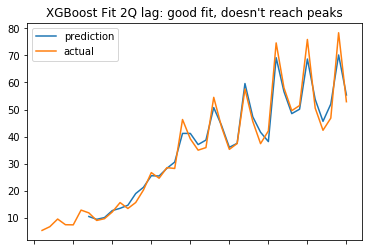

In [108]:
# Plot to see what's going on -> depends on hyperparams but tends to overfit
# Get predictions for plotting
dpred_train = xgb.DMatrix(X3.iloc[4:-5,:].values)
y5_pred = model.predict(dpred_train)

# Set up plots
fig, ax = plt.subplots()
plt.plot(y5_pred,label='prediction') # predictions
rev.iloc[4:].plot(ax=ax, label='actual') # actual revenue
plt.gca().invert_xaxis() # so time increases going right
plt.title("XGBoost Fit 2Q lag: good fit, doesn't reach peaks")
plt.legend()
plt.show()

## Prediction based on default-params xgboost run: \$281bn
This is wildly off - I haven't touched the hyperparams since setting up the pipeline.<br>
NB Q4 prediction looks quite good, which is what this model was built for (hence the 2-quarter lag); though it should do well on Q3 too.

In [96]:
# Credit for tuning: https://cambridgespark.com/content/tutorials/hyperparameter-tuning-in-xgboost/index.html
# I have modified this code to account for the smaller dataset (I've done one large gridsearch)
# and stricter learning objective (rmse instead of mae, since being twice as wrong is more than twice as bad)

# get baseline mse
mse_baseline = mean_squared_error(y3_test, xgb_pred2)
print('mse baseline is {:2f}'.format(mse_baseline))
train_mse_baseline = mean_squared_error(y3_train, model.predict(dtrain))
print('mse training baseline is {:2f}'.format(train_mse_baseline))

# -> 72, so mean error is about $8.5bn. Not very good.

mse baseline is 72.167268
mse training baseline is 0.050587


In [97]:
params = {
    # Parameters to tune
    'max_depth': 6,
    'min_child_weight': 1,
    'eta': 0.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Fixed param
    'objective':'reg:linear',
    'eval_metric':'rmse'
}

# max rounds to check improvement
num_boost_rounds = 999

# model
model = xgb.train(params, dtrain, num_boost_round=num_boost_rounds,
                  evals=[(dtest,'Test')], early_stopping_rounds=10)

print('Best rmse of {:2f} after {} rounds'.format(model.best_score,model.best_iteration+1))

[0]	Test-rmse:22.341
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:14.0577
[2]	Test-rmse:8.67198
[3]	Test-rmse:6.7898
[4]	Test-rmse:4.20161
[5]	Test-rmse:4.24522
[6]	Test-rmse:4.56385
[7]	Test-rmse:5.31377
[8]	Test-rmse:5.88248
[9]	Test-rmse:6.21394
[10]	Test-rmse:6.46997
[11]	Test-rmse:6.75284
[12]	Test-rmse:6.96942
[13]	Test-rmse:7.12744
[14]	Test-rmse:7.27987
Stopping. Best iteration:
[4]	Test-rmse:4.20161

Best rmse of 4.201607 after 5 rounds


### Cross-validate to tune parameters

In [98]:
# Cross validation
# Visualise process
cv_results = xgb.cv(params, dtrain, num_boost_rounds, nfold=5, seed=4, metrics={'rmse'},early_stopping_rounds=10)
cv_results

,test-rmse-mean,test-rmse-std,train-rmse-mean,train-rmse-std
0,31.706259,5.888746,31.923111,1.185313
1,24.315457,5.917599,23.894042,0.899227
2,19.095624,5.857959,18.084417,0.679765
3,15.443245,4.864519,13.795751,0.519790
4,13.381009,3.988934,10.611408,0.375961
5,12.423242,3.659171,8.217666,0.302554
6,11.859531,3.250019,6.408035,0.247513
7,11.815272,2.985409,5.055577,0.207138
8,11.780553,2.818244,4.040302,0.186930
9,11.643810,2.833415,3.262417,0.180547


In [127]:
# Observation on cv_results: n-fold test sets aren't being as well fitted as the manually partitioned test set above.

In [134]:
# massive gridsearch since tiny dataset

# Gridsearch: (default depth in (9,12), weight in (5,8); let's try wider then keep narrowing)
gridsearch_params = [
    (max_depth, min_child_weight, eta, subsample, colsample)
    for max_depth in range(9,12)
    for min_child_weight in range(5,8)
    for eta in [.3, .2, .1, .05, .01, .005]
    for subsample in [i/10.0 for i in range(7,11)]
    for colsample in [i/10.0 for i in range(7,11)]
]

In [148]:
### WARNING: took me 821 seconds

# Initialise for recording bests
min_rmse = float('Inf')
best_params = None

# Big loop: this may take a while
start_time = timeit.default_timer()
for max_depth, min_child_weight, eta, subsample, colsample in gridsearch_params:
    
    # Print out hyperparams
    print('For CV with max_depth={}, min_child_weight={}, eta={}, subsample{}, colsample={}'\
         .format(max_depth, min_child_weight, eta, subsample, colsample))
    
    # Update params
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['eta'] = eta
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    # Cross-validate
    cv_results = xgb.cv(params, dtrain, num_boost_rounds, nfold=5, seed=4, metrics={'rmse'},early_stopping_rounds=10)
    
    # Update scores
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    # Print error & round
    print('RMSE: {}, round: {}'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight, eta, subsample, colsample)

end_time = timeit.default_timer()        
        
print('Best parameters: {}, {}, {}, {}, {}; RMSE: {}'.format(
    best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], min_rmse))

print('Time elapsed: {}'.format(end_time-start_time))

For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.7, colsample=0.7
RMSE: 9.280488199999999, round: 13
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.7, colsample=0.8


/home/jesse/anaconda2/envs/dl_env_1/lib/python3.5/site-packages/ipykernel/__main__.py:24: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


RMSE: 9.390104, round: 37
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.7, colsample=0.9
RMSE: 10.4036622, round: 19
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.7, colsample=1.0
RMSE: 10.234685000000002, round: 19
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.8, colsample=0.7
RMSE: 10.200241, round: 15
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.8, colsample=0.8
RMSE: 9.780659400000001, round: 19
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.8, colsample=0.9
RMSE: 10.1046654, round: 13
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.8, colsample=1.0
RMSE: 10.0760014, round: 13
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.9, colsample=0.7
RMSE: 10.128360400000002, round: 15
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.9, colsample=0.8
RMSE: 10.1850704, round: 17
For CV with max_depth=9, min_child_weight=5, eta=0.3, subsample0.9, cols

ValueError: unexpected '{' in field name

In [149]:
print('Best parameters: {}, {}, {}, {}, {}; RMSE: {}'.format(
    best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], min_rmse))

print('Time elapsed: {}'.format(end_time-start_time))

Best parameters: 9, 7, 0.2, 0.9, 0.8; RMSE: 7.999657599999999
Time elapsed: 821.7312907630003


In [159]:
# Max_depth was optimised at the boundary; perhaps lower values reduce RMSE further
# NB optimise with min_child_weight to balance bias-variance



# Gridsearch: (default depth in (9,12), weight in (5,8); if time, try wider then keep narrowing)
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(1,9)
    for min_child_weight in range(5,8)
]

# Update params with other 3 found above
params['eta'] = 0.2
params['subsample'] = 0.9
params['colsample_bytree'] = 0.8

# Initialise for recording bests
min_rmse = float('Inf')
# best_params = None

# Small loop
start_time = timeit.default_timer()
for max_depth, min_child_weight in gridsearch_params:
    
    # Print out hyperparams
    print('For CV with max_depth={}, min_child_weight={}, eta={}, subsample{}, colsample={}'\
         .format(max_depth, min_child_weight, params['eta'], params['subsample'], params['colsample_bytree']))
    
    # Update param
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    # Cross-validate
    cv_results = xgb.cv(params, dtrain, num_boost_rounds, nfold=5, seed=4, metrics={'rmse'},early_stopping_rounds=10)
    
    # Update scores
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    # Print error & round
    print('RMSE: {}, round: {}'.format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, min_child_weight, params['eta'], params['subsample'], params['colsample_bytree'])

end_time = timeit.default_timer()        
        
print('Best parameters: {}, {}, {}, {}, {}; RMSE: {}'.format(
    best_params[0], best_params[1], best_params[2], best_params[3], best_params[4], min_rmse))

print('Time elapsed: {}'.format(end_time-start_time))

For CV with max_depth=1, min_child_weight=5, eta=0.2, subsample0.9, colsample=0.8


/home/jesse/anaconda2/envs/dl_env_1/lib/python3.5/site-packages/ipykernel/__main__.py:37: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.


RMSE: 9.114006999999999, round: 135
For CV with max_depth=1, min_child_weight=6, eta=0.2, subsample0.9, colsample=0.8
RMSE: 8.4418222, round: 152
For CV with max_depth=1, min_child_weight=7, eta=0.2, subsample0.9, colsample=0.8
RMSE: 8.144779400000001, round: 90
For CV with max_depth=2, min_child_weight=5, eta=0.2, subsample0.9, colsample=0.8
RMSE: 9.261090399999999, round: 65
For CV with max_depth=2, min_child_weight=6, eta=0.2, subsample0.9, colsample=0.8
RMSE: 8.7759648, round: 89
For CV with max_depth=2, min_child_weight=7, eta=0.2, subsample0.9, colsample=0.8
RMSE: 7.911290599999999, round: 114
For CV with max_depth=3, min_child_weight=5, eta=0.2, subsample0.9, colsample=0.8
RMSE: 9.410219600000001, round: 51
For CV with max_depth=3, min_child_weight=6, eta=0.2, subsample0.9, colsample=0.8
RMSE: 9.3922484, round: 37
For CV with max_depth=3, min_child_weight=7, eta=0.2, subsample0.9, colsample=0.8
RMSE: 7.999657599999999, round: 117
For CV with max_depth=4, min_child_weight=5, eta=

In [161]:
# A small improvement, at a surprisingly small 2 max_depth!
best_params

(2, 7, 0.2, 0.9, 0.8)

In [101]:
params['max_depth'] = 2
params['min_child_weight'] = 7
params['subsample'] = 0.9
params['eta'] = 0.2
params['colsample_bytree'] = 0.8
print(params)
"""
{'colsample_bytree': 0.8,
 'eta': 0.2,
 'eval_metric': 'rmse',
 'max_depth': 2,
 'min_child_weight': 7,
 'objective': 'reg:linear',
 'subsample': 0.9}
 """

{'objective': 'reg:linear', 'max_depth': 2, 'eval_metric': 'rmse', 'min_child_weight': 7, 'subsample': 0.9, 'eta': 0.2, 'colsample_bytree': 0.8}


"\n{'colsample_bytree': 0.8,\n 'eta': 0.2,\n 'eval_metric': 'rmse',\n 'max_depth': 2,\n 'min_child_weight': 7,\n 'objective': 'reg:linear',\n 'subsample': 0.9}\n "

In [102]:
# Train a model on best hyperparameters
num_boost_rounds = 999

# model
model = xgb.train(params, dtrain, num_boost_round=num_boost_rounds,
                  evals=[(dtest,'Test')], early_stopping_rounds=10)

print('Best rmse of {:2f} after {} rounds'.format(model.best_score,model.best_iteration+1))

[0]	Test-rmse:26.1318
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:19.4194
[2]	Test-rmse:15.9682
[3]	Test-rmse:12.2773
[4]	Test-rmse:8.99864
[5]	Test-rmse:6.2592
[6]	Test-rmse:4.44477
[7]	Test-rmse:3.84166
[8]	Test-rmse:3.02398
[9]	Test-rmse:3.28337
[10]	Test-rmse:4.35089
[11]	Test-rmse:4.41228
[12]	Test-rmse:4.55828
[13]	Test-rmse:4.64842
[14]	Test-rmse:4.63493
[15]	Test-rmse:4.75856
[16]	Test-rmse:5.14514
[17]	Test-rmse:5.22306
[18]	Test-rmse:5.57821
Stopping. Best iteration:
[8]	Test-rmse:3.02398

Best rmse of 3.023977 after 9 rounds


In [103]:
# A substantial improvement in accuracy, though not as good as I'd like. 

# Get predictions
# Get predictions for Q4
dpred_Q4 = xgb.DMatrix(df_new3.iloc[1:2,1:].values)
pred_xgb_Q4 = model.predict(dpred_Q4)
# For Q3
dpred_Q3 = xgb.DMatrix(df_new3.iloc[2:3,1:].values)
pred_xgb_Q3 = model.predict(dpred_Q3)

print("Prediction for Q3: ", pred_xgb_Q3)
print("Prediction for Q4: ", pred_xgb_Q4)

# FY2018 prediction

#print("FY2018 pred:",round(FY2018_pred_xgb,1))
print(H1+pred_xgb_Q4[0]+pred_xgb_Q3[0])

Prediction for Q3:  [52.896305]
Prediction for Q4:  [46.458267]
248.78457229614258


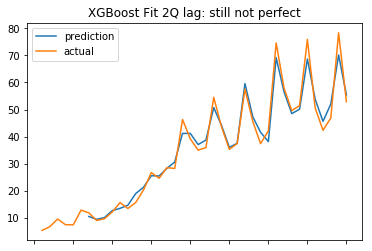

In [105]:
# Plot to see what's going on -> depends on hyperparams but tends to overfit
# Get predictions for plotting
dpred_train = xgb.DMatrix(X3.iloc[4:-5,:].values)
y5_pred = model.predict(dpred_train)

# Set up plots
fig, ax = plt.subplots()
plt.plot(y5_pred,label='prediction') # predictions
rev.iloc[4:].plot(ax=ax, label='actual') # actual revenue
plt.gca().invert_xaxis() # so time increases going right
plt.title('XGBoost Fit 2Q lag: still not perfect')
plt.legend()
plt.show()

## Prediction with tuned xgboost: $249bn

# (5) Final prediction: $267bn
This is a humble arithmetic mean of both xgboost predictions and the boosted trees, as below.
## Conviction: low
The xgboost models are underfitting. There is possibly an issue with the lagged features, or a bug, but I am out of time.

In [106]:
# mean prediction for FY2018
sum([272, 281, 249])/3

267.3333333333333

# If I had more time
Besides improving the given models (I have commented above on various shortcuts taken, like patent-indicator-lag; I suspect pruning features would help a bit even with xgboost; financial calculations like growth, capital adequacy, measures of solvency and liquidity etc are likely to help), I would move on quickly to the NYSE data set to predict most recent revenue given previous years' financials for tech companies.

I would love to apply deep learning to this problem (LSTM, say) but I feel getting better and bigger data is more urgent than tweaking the model architecture. There must be features in the overall stock market that are relevant to Apple.

In [112]:
y.values

(45,)